In [1]:
# Instalar dependencias necesarias (sin xvfb ni pyvirtualdisplay)
!pip install pyglet==1.5.1
!pip install gym==0.24
!pip install pygame
!pip install numpy
!pip install imageio imageio_ffmpeg

In [2]:
!pip install gym==0.24
!pip install pygame
!pip install numpy
!pip install tqdm
!pip install imageio imageio_ffmpeg

In [1]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

In [2]:
# Crear un mapa personalizado de FrozenLake
custom_map = [
    'SFFF',  # S es el punto de inicio (Start)
    'HHHH',  # H son obstáculos (Holes)
    'FFFH',
    'HFFG'  # G es la meta (Goal)
]

# Crear el entorno con el mapa personalizado
env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=False)

In [3]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 12


In [4]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 2


In [5]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [6]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [7]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

In [8]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_int = random.uniform(0,1)
  # if random_int > greater than epsilon --> exploitation
  if random_int > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = np.argmax(Qtable[state])
  # else --> exploration
  else:
    action = env.action_space.sample()
  
  return action

In [9]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])
  
  return action

In [10]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability 
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [11]:
from tqdm import trange

def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    success_count = 0  # Contador para éxitos (cuando el agente llega a la meta)
    hole_count = 0  # Contador para fracasos (cuando el agente cae en un agujero)
    
    successful_episodes = []
    hole_episodes = []
    first_success_episode = None

    for episode in trange(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state = env.reset()
        done = False
        step = 0

        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done, info = env.step(action)

            # Modificación de las recompensas según tus reglas:
            if new_state == 15:  # Si el agente llega a la meta
                reward = 1  # Recompensa de +1 por alcanzar la meta
            elif new_state in [4, 5, 6, 7, 11, 12]:  # Si el agente cae en un agujero
                reward = 0  # Recompensa 0 por caer en un agujero
            else:
                reward = 0  # Recompensa 0 por moverse sin llegar a la meta o caer en un agujero

            # Actualiza Q(s,a)
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )

            # Si el episodio termina
            if done:
                if reward == 1:  # Si llega a la meta, cuenta como éxito
                    success_count += 1
                    successful_episodes.append(episode)
                    if first_success_episode is None:
                        first_success_episode = episode
                elif reward == 0 and new_state in [5, 7, 11, 12]:  # Si cae en un agujero, cuenta como fracaso
                    hole_count += 1
                    hole_episodes.append(episode)
                break

            state = new_state

    # Resultados
    print(f"Total de éxitos (llegó al objetivo): {success_count}")
    print(f"Total de fracasos (cayó en agujeros): {hole_count}")
    print(f"Episodios exitosos: {successful_episodes}")
    print(f"Episodios donde cayó en agujeros: {hole_episodes}")
    if first_success_episode is not None:
        print(f"Primer episodio exitoso (llegó a la meta): {first_success_episode}")
    else:
        print("El agente no alcanzó la meta en ningún episodio.")

    return Qtable

In [12]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

100%|██████████| 10000/10000 [00:05<00:00, 1734.70it/s]

Total de éxitos (llegó al objetivo): 0
Total de fracasos (cayó en agujeros): 644
Episodios exitosos: []
Episodios donde cayó en agujeros: [0, 1, 2, 6, 9, 10, 12, 15, 19, 22, 25, 27, 28, 29, 34, 38, 47, 56, 69, 80, 83, 94, 95, 98, 102, 105, 112, 114, 118, 127, 135, 141, 145, 147, 148, 151, 155, 156, 161, 164, 166, 168, 170, 171, 177, 184, 185, 188, 193, 197, 200, 203, 204, 210, 221, 222, 224, 226, 231, 235, 246, 251, 253, 259, 268, 269, 270, 272, 281, 289, 295, 297, 299, 304, 312, 320, 328, 329, 330, 331, 335, 339, 342, 343, 346, 355, 357, 358, 361, 363, 367, 371, 372, 373, 375, 376, 380, 384, 385, 387, 394, 395, 396, 397, 398, 401, 416, 417, 430, 432, 435, 441, 449, 454, 460, 463, 467, 469, 478, 480, 481, 482, 483, 488, 490, 491, 496, 498, 500, 502, 504, 509, 516, 519, 520, 533, 537, 542, 546, 552, 557, 558, 564, 566, 567, 575, 579, 586, 588, 590, 616, 622, 628, 633, 636, 637, 638, 641, 650, 665, 673, 676, 678, 680, 682, 687, 710, 712, 718, 721, 728, 730, 737, 743, 751, 756, 758, 763, 

In [13]:
import pandas as pd

def print_qtable(Qtable):
    actions = ["Left", "Down", "Right", "Up"]
    df_qtable = pd.DataFrame(Qtable, columns=actions)
    print(df_qtable)

# Llamar a la función después del entrenamiento
print_qtable(Qtable_frozenlake)

    Left  Down  Right   Up
0    0.0   0.0    0.0  0.0
1    0.0   0.0    0.0  0.0
2    0.0   0.0    0.0  0.0
3    0.0   0.0    0.0  0.0
4    0.0   0.0    0.0  0.0
5    0.0   0.0    0.0  0.0
6    0.0   0.0    0.0  0.0
7    0.0   0.0    0.0  0.0
8    0.0   0.0    0.0  0.0
9    0.0   0.0    0.0  0.0
10   0.0   0.0    0.0  0.0
11   0.0   0.0    0.0  0.0
12   0.0   0.0    0.0  0.0
13   0.0   0.0    0.0  0.0
14   0.0   0.0    0.0  0.0
15   0.0   0.0    0.0  0.0


In [14]:
def show_policy(Qtable):
    actions = ['←', '↓', '→', '↑']
    policy = np.argmax(Qtable, axis=1)  # Encontrar la mejor acción para cada estado
    policy_grid = np.array(actions)[policy].reshape((4, 4))  # Ajustar al tamaño del mapa
    print(policy_grid)

# Visualizar la política aprendida
show_policy(Qtable_frozenlake)

[['←' '←' '←' '←']
 ['←' '←' '←' '←']
 ['←' '←' '←' '←']
 ['←' '←' '←' '←']]


In [15]:
Qtable_frozenlake

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [16]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [17]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=0.00 +/- 0.00


In [18]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []  
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [19]:
import os
import imageio

video_fps=1
# Definir la ruta de salida
output_directory = 'C:\\Users\\Lenovo\\Videos'
output_path = os.path.join(output_directory, 'video3.mp4')

# Crear el directorio si no existe (aunque en este caso debería existir)
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Ahora guarda el video en el directorio correcto
def record_video(env, Qtable, out_directory, fps):
    images = []
    done = False
    state = env.reset()
    while not done:
        action = np.argmax(Qtable[state])
        state, reward, done, info = env.step(action)
        img = env.render(mode='rgb_array')
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

# Usar la nueva ruta de salida
record_video(env, Qtable_frozenlake, output_path, video_fps)

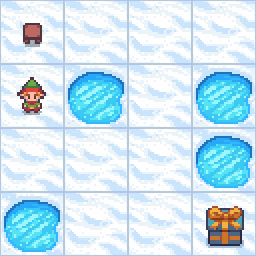

In [23]:
from IPython.display import Image
Image('C:\\Users\\Lenovo\\Videos\\video.gif')